# Dirac Notation Implementation - DEMO

2024-03-01

## Set up the environment

In [1]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
session = WolframLanguageSession()

In [2]:
from diracdec import *
from diracdec import dirac_bigop_delta_parse as parse, dirac_bigop_delta_trs as trs

In [3]:
sub = Subst({
    "ket0" : parse('''KET('0')'''),
    "bra0" : parse('''BRA('0')'''),
    "ket1" : parse('''KET('1')'''),
    "bra1" : parse('''BRA('1')'''),
    "ketP" : parse(''' "Sqrt[1/2]" SCRK (ket0 ADDK ket1) '''),
    "braP" : parse(''' "Sqrt[1/2]" SCRB (bra0 ADDB bra1) '''),
    "ketM" : parse(''' "Sqrt[1/2]" SCRK (ket0 ADDK ("-1" MLTK ket1)) '''),
    "braM" : parse(''' "Sqrt[1/2]" SCRB (bra0 ADDB ("-1" MLTB bra1)) '''),

    "beta00" : parse(''' "Sqrt[1/2]" SCRK ((ket0 TSRK ket0) ADDK (ket1 TSRK ket1))'''),

    "I2" : parse('''(ket0 OUTER bra0) ADDO (ket1 OUTER bra1)'''),

    "Z" : parse('''(ket0 OUTER bra0) ADDO ("-1" SCRO (ket1 OUTER bra1))'''),

    "X" : parse('''(ket0 OUTER bra1) ADDO (ket1 OUTER bra0)'''),

    "Y" : parse('''("-I" SCRO (ket0 OUTER bra1)) ADDO ("I" SCRO (ket1 OUTER bra0))'''),


    "H" : parse(''' "Sqrt[1/2]" SCRO ((ket0 OUTER bra0) ADDO (ket0 OUTER bra1) ADDO (ket1 OUTER bra0) ADDO ("-1" SCRO (ket1 OUTER bra1)))'''),

    "CX": parse(''' ((ket0 TSRK ket0) OUTER (bra0 TSRB bra0))
                ADDO ((ket0 TSRK ket1) OUTER (bra0 TSRB bra1)) 
                ADDO ((ket1 TSRK ket1) OUTER (bra1 TSRB bra0))
                ADDO ((ket1 TSRK ket0) OUTER (bra1 TSRB bra1))'''),

    "CZ": parse(''' ((ket0 TSRK ket0) OUTER (bra0 TSRB bra0))
                ADDO ((ket0 TSRK ket1) OUTER (bra0 TSRB bra1)) 
                ADDO ((ket1 TSRK ket0) OUTER (bra1 TSRB bra0))
                ADDO ("-1" SCRO ((ket1 TSRK ket1) OUTER (bra1 TSRB bra1)))'''),

}).get_idempotent()


In [4]:
print(sub)

┌───────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                           │
│        ⎛   1               ⎞                                                                              │
│ ketP ↦ ⎜-------.(|0> + |1>)⎟                                                                              │
│        ⎝Sqrt[2]            ⎠                                                                              │
│                                                                                                           │
│        ⎛   1                    ⎞                                                                         │
│ braM ↦ ⎜-------.(<0| + (-1·<1|))⎟                                                                         │
│        ⎝Sqrt[2]                 ⎠                                                                         │
│         

## Examples

### Basic Gates

 \left (\frac{1}{\sqrt{2}}\right )  \left (  |1 \rangle  \langle 0 | +   |0 \rangle  \langle 0 | +   |0 \rangle  \langle 1 | +  \left (-1\right )   |1 \rangle  \langle 1 | \right )


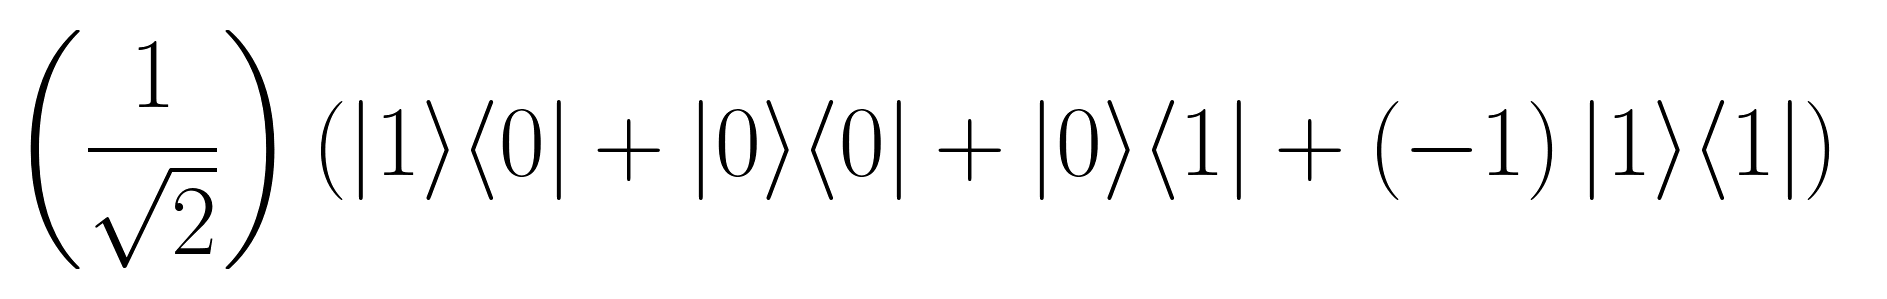

In [5]:
print(sub(parse(''' H ''')).tex())
sub(parse(''' H ''')).render_tex()

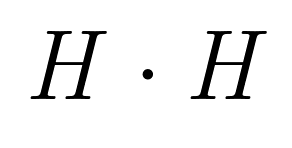

In [6]:
expr = parse(''' H MLTO H''')
expr.render_tex()

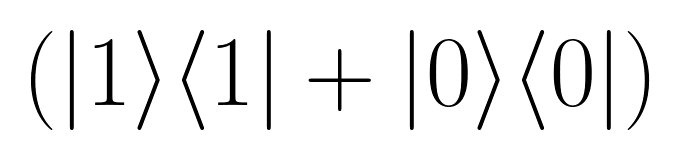

In [7]:
trs.normalize(sub(expr)).render_tex()

### Utilizing Wolfram Engine

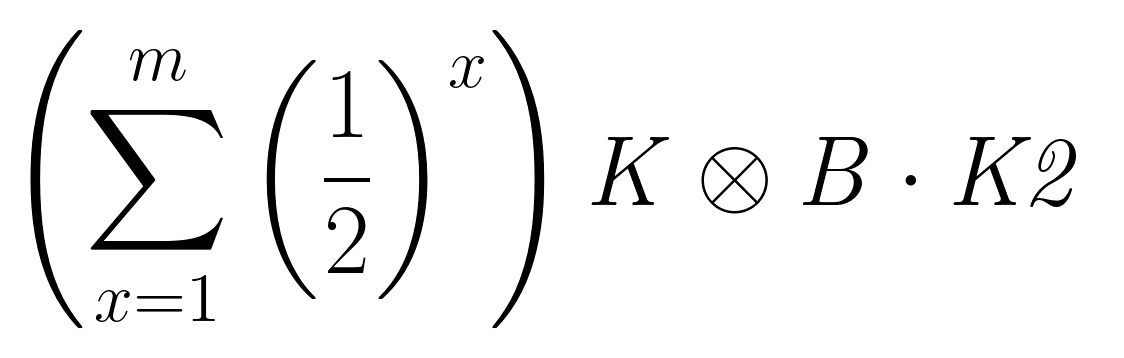

In [8]:
expr = parse(''' "HoldForm[Sum[(1/2)^x, {x, 1, m}]]" SCRO ((K OUTER B) MLTK K2) ''')
expr.render_tex()

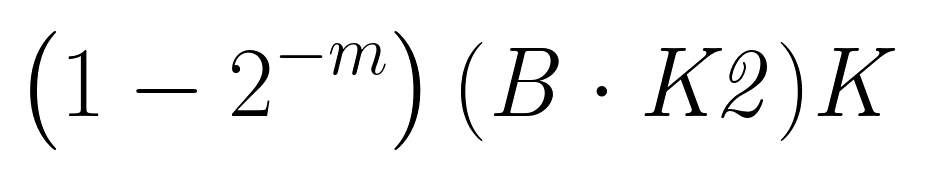

In [10]:
trs.normalize(expr).render_tex()

### Rotation decompostion

In [11]:

# define the rotation gates
sub_rot = Subst({
    "Rz" : sub(parse(
        ''' FUN beta . ( ("Cos[beta/2]" SCRO I2) ADDO ("- Sin[beta/2] I" SCRO Z) )'''
        )),

    "Ry" : sub(parse(
        ''' FUN gamma . ( ("Cos[gamma/2]" SCRO I2) ADDO ("- Sin[gamma/2] I" SCRO Y) )'''
        )),
})


# get the idempotent operation
new_sub = sub_rot.composite(sub).get_idempotent()

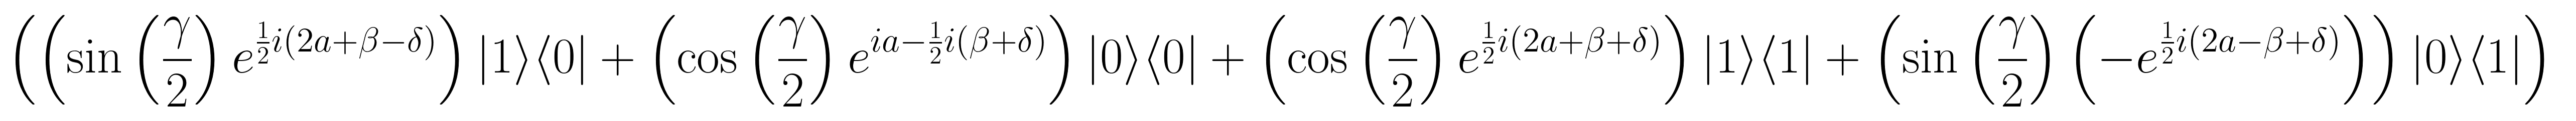

In [12]:
# RHS - rotations
a = new_sub(parse(''' "Exp[I a]" SCRO ((Rz @ beta) MLTO (Ry @ gamma) MLTO (Rz @ delta)) '''))
norm_a = trs.normalize(sub(a))
norm_a.render_tex()

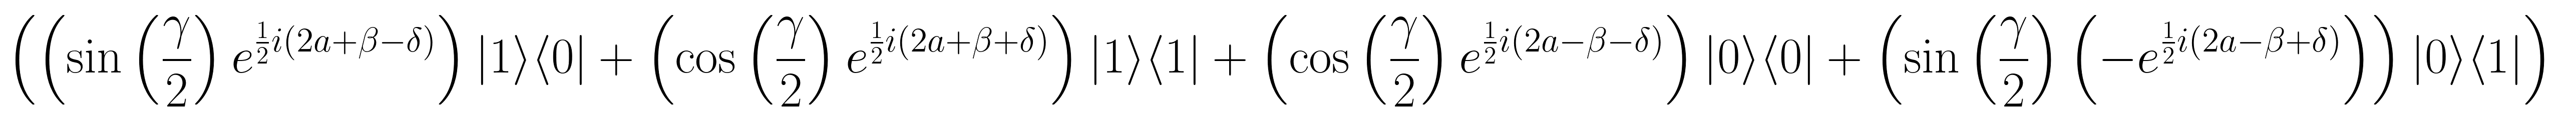

In [13]:
b = new_sub(parse(''' ("Exp[I (a - beta/2 - delta/2)] Cos[gamma/2]" SCRO (ket0 OUTER bra0))
    ADDO ("- Exp[I (a - beta/2 + delta/2)] Sin[gamma/2]" SCRO (ket0 OUTER bra1)) 
    ADDO ("Exp[I (a + beta/2 - delta/2)] Sin[gamma/2]" SCRO (ket1 OUTER bra0))
    ADDO ("Exp[I (a + beta/2 + delta/2)] Cos[gamma/2]" SCRO (ket1 OUTER bra1))'''))
norm_b = trs.normalize(sub(b))
norm_b.render_tex()

In [14]:
print("equivalence without unique scalar table: ", norm_a == norm_b)
print("equivalence with unique: scalar table: ", wolU(norm_a) == wolU(norm_b))

equivalence without unique scalar table:  False
equivalence with unique: scalar table:  True


### Operation on Maximally Entangled State

For all $A$,
$$
A_{S} \ket{\Phi}_{S, T} = A^\top_{T} \ket{\Phi}_{S, T}
$$
where
$$
\ket{\Phi} = \sum_{i}\ket{i}\ket{i}
$$

In [15]:
a = parse(''' 
                (
                    (
                        SUM(i, KET(i) OUTER BRA(i)) TSRO 1O
                    ) 
                    MLTO (A TSRO 1O)
                ) 
                MLTK 
                (
                    SUM(i, KET(PAIR(i, i)))
                ) 
            ''')

b = parse(''' 
                (
                    (1O TSRO SUM(i, KET(i) OUTER BRA(i))) MLTO (1O TSRO TRANO(A))
                ) 
                MLTK 
                (
                    SUM(i, KET(PAIR(i, i)))
                ) 
            ''')

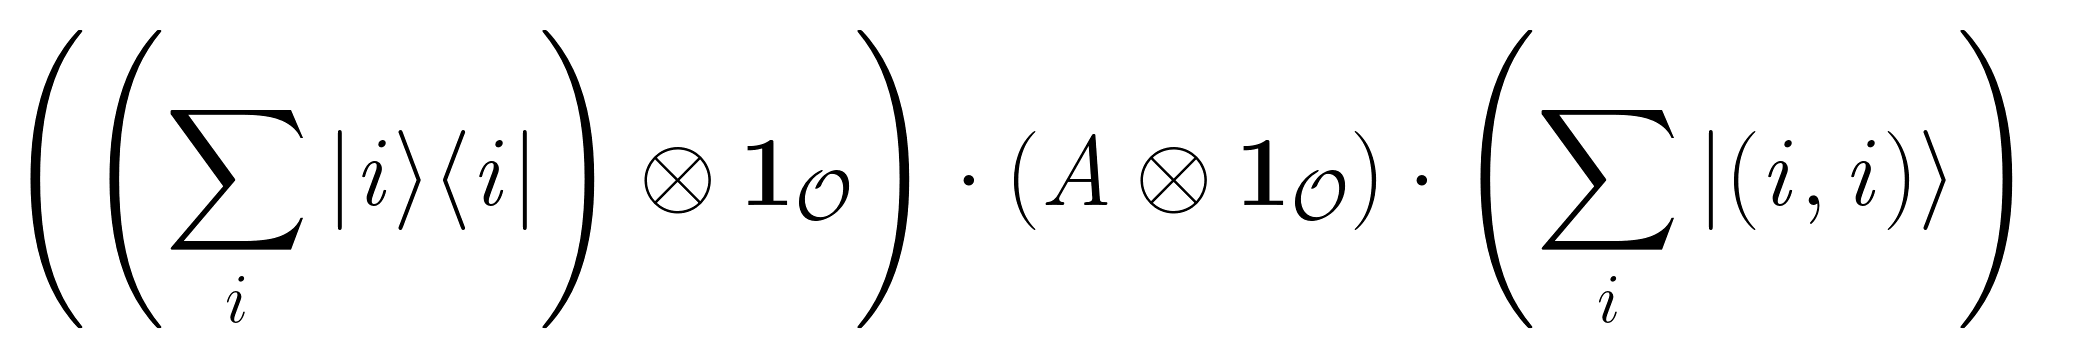

In [16]:
a.render_tex()

In [17]:
print(a)

⎛⎛⎛__             ⎞       ⎞ __         ⎞
⎜⎜⎜\              ⎟       ⎟ \          ⎟
⎜⎜⎜/  (|i>⊗<i|)⊗1O⎟·(A⊗1O)⎟·/  |(i, i)>⎟
⎜⎜⎜‾‾             ⎟       ⎟ ‾‾         ⎟
⎝⎝⎝i              ⎠       ⎠ i          ⎠


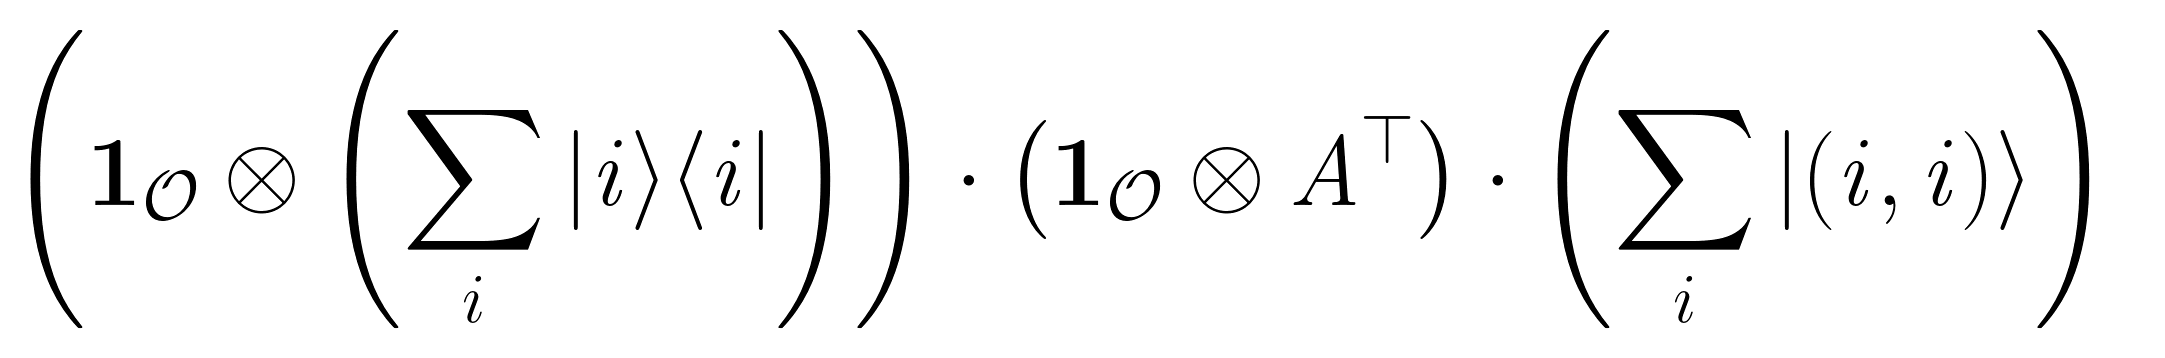

In [18]:
b.render_tex()

In [19]:
norm_a = trs.normalize(a)
norm_b = trs.normalize(b)

assert trs.normalize(juxt(sumeq(norm_a))) == trs.normalize(juxt(sumeq(norm_b)))

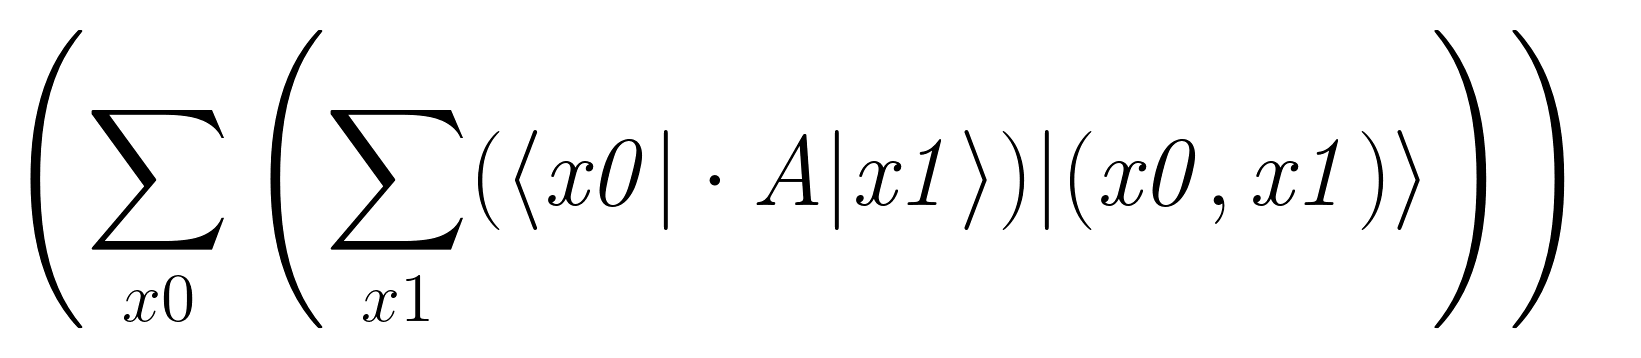

In [20]:
trs.normalize(juxt(sumeq(norm_a))).render_tex()

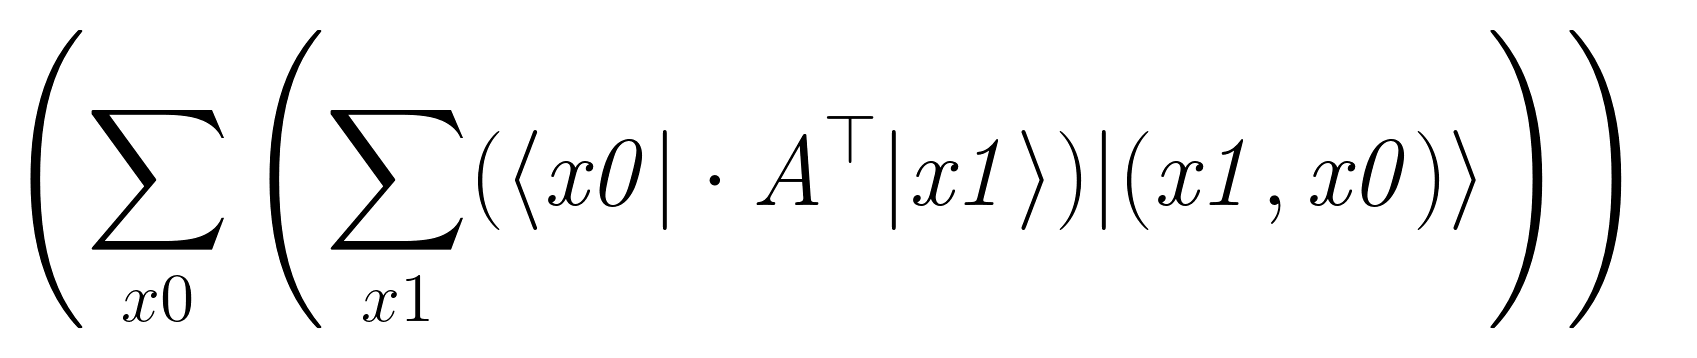

In [21]:
trs.normalize(juxt(sumeq(norm_b))).render_tex()

### abstraction and application: Choi representation

In [22]:
choi_sub = Subst({
"choi" : parse(r''' 
FUN A . SUM(i, 
            SUM(j, 
                (BRA(i) DOT (A MLTK KET(j)))
                SCRK KET(PAIR(i,j))
            )    
        ) '''),
"unchoi" : parse(r'''
FUN A . SUM(i,
            SUM(j,
                (BRA(PAIR(i, j)) DOT A)
                SCRO (KET(i) OUTER BRA(j))
                )
        )''')
}).get_idempotent()

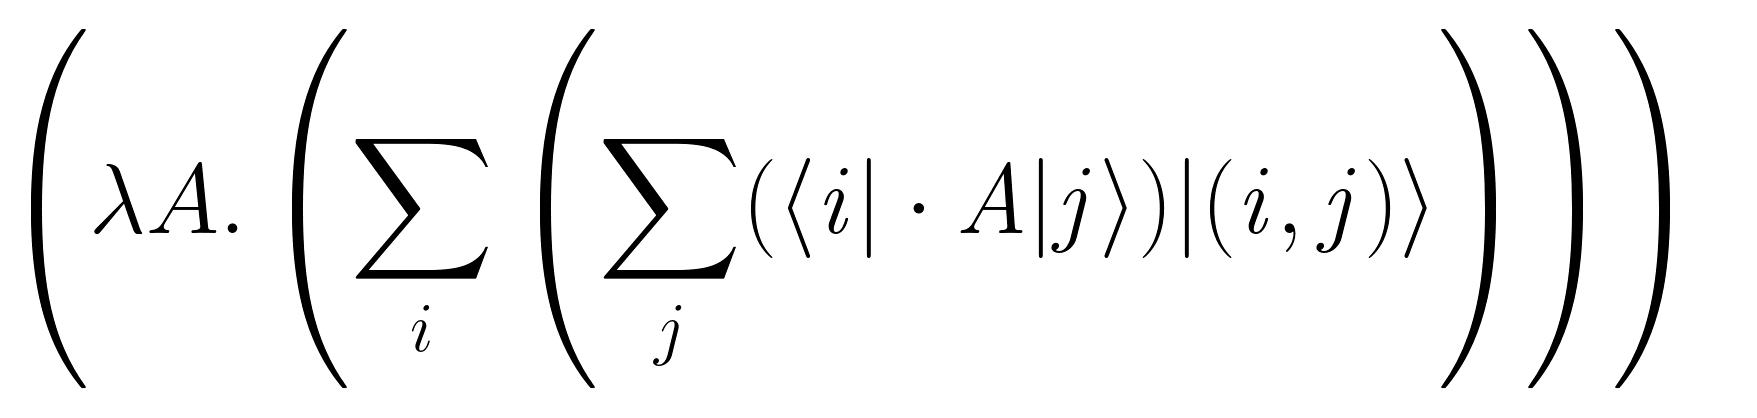

In [23]:
a = choi_sub(parse(r'''choi'''))
a.render_tex()

In [24]:
print(a)

⎛    __ __                         ⎞
⎜    \  \                          ⎟
⎜λ A./  /  ((<i|·(A·|j>)).|(i, j)>)⎟
⎜    ‾‾ ‾‾                         ⎟
⎝    i  j                          ⎠


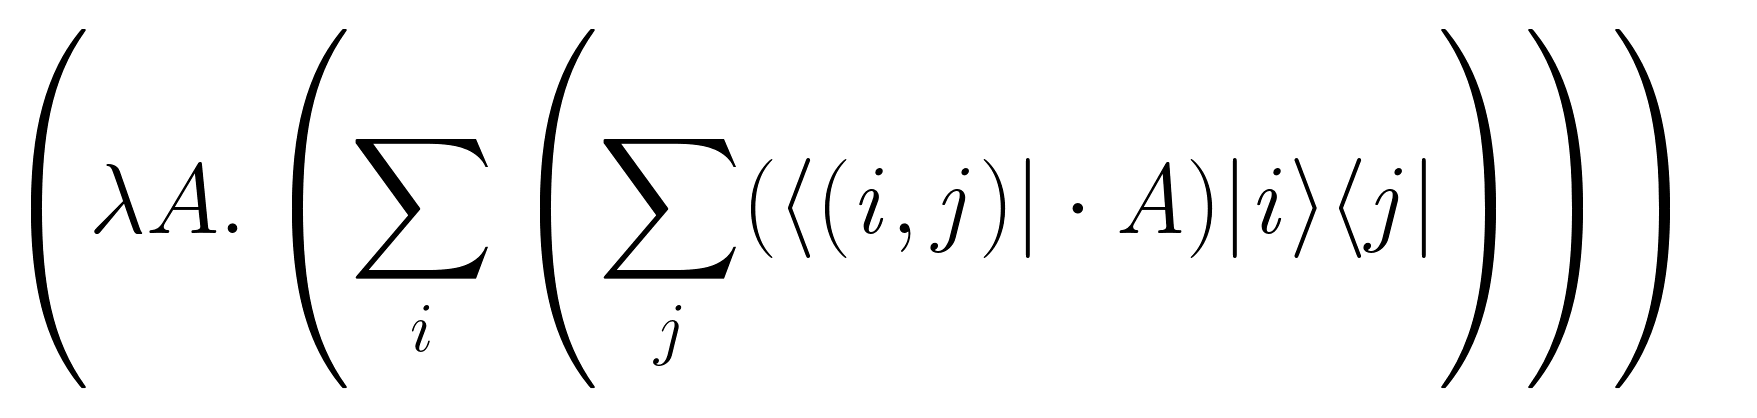

In [25]:
b = choi_sub(parse(r'''unchoi'''))
b.render_tex()

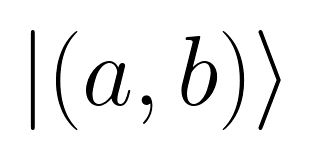

In [26]:
a_ = choi_sub(parse(r''' choi @ (KET('a') OUTER BRA('b')) '''))
trs.normalize(a_).render_tex()

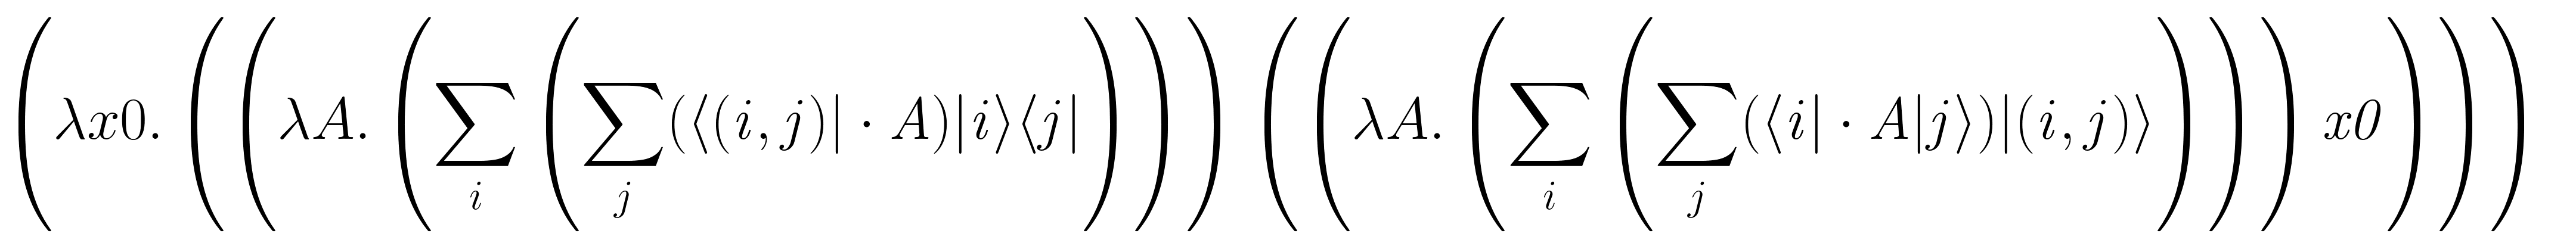

In [27]:
c = choi_sub(parse(r'''FUN A . unchoi @ (choi @ A) '''))
c.render_tex()

In [28]:
trs.normalize(c, verbose=True)

== STEP 1 ==
Current Term:
⎛     ⎛    __ __                         ⎞ ⎛    __ __                         ⎞   ⎞
⎜     ⎜    \  \                          ⎟ ⎜    \  \                          ⎟   ⎟
⎜λ x0.⎜λ A./  /  ((<(i, j)|·A).(|i>⊗<j|))⎟ ⎜λ A./  /  ((<i|·(A·|j>)).|(i, j)>)⎟ x0⎟
⎜     ⎜    ‾‾ ‾‾                         ⎟ ⎜    ‾‾ ‾‾                         ⎟   ⎟
⎝     ⎝    i  j                          ⎠ ⎝    i  j                          ⎠   ⎠

┌apply BETA_REDUCTION──────────────────────────────────────────────────────┐
│⎛    __ __                         ⎞       __ __                          │
│⎜    \  \                          ⎟       \  \                           │
│⎜λ A./  /  ((<i|·(A·|j>)).|(i, j)>)⎟ x0 -> /  /  ((<i|·(x0·|j>)).|(i, j)>)│
│⎜    ‾‾ ‾‾                         ⎟       ‾‾ ‾‾                          │
│⎝    i  j                          ⎠       i  j                           │
└──────────────────────────────────────────────────────────────────────────┘


== STEP 2 =

LAMBDA[x0](x0)

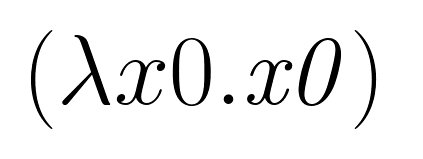

In [29]:
trs.normalize(c).render_tex()

## Playground

In [30]:
a = parse(''' "Hold[Sum[(1/2)^i, {i,1,Infinity}] a + a] " ''')

a.tex()
# trs.normalize(a).render_tex()


'\\left (\\text{Hold}\\left[a \\left(\\sum _{i=1}^{\\infty } \\left(\\frac{1}{2}\\right)^i\\right)+a\\right]\\right )'

In [31]:
b = session.evaluate(" Hold[Sum[(1/2)^i, {i,1,Infinity}] a + a] ")